<a href="https://colab.research.google.com/github/AKookani/NLP/blob/main/LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset
import matplotlib.pyplot as plt
#import evaluate

# Load pre-trained model and tokenizer
model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)  # Updated to 6 labels

# Tokenize dataset
def preprocess_function(examples):
    inputs = examples["text"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = examples["label"]
    return model_inputs

# Load the emotion dataset
dataset = load_dataset("dair-ai/emotion")
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Specify task type for sequence classification
    r=8,  # Low-rank dimension
    lora_alpha=16,  # LoRA scaling factor
    target_modules=["q_proj", "v_proj"],  # Apply LoRA to query and value projections
    lora_dropout=0.1  # Dropout to avoid overfitting
)

# Apply LoRA to the model
peft_model = get_peft_model(model, lora_config)
print("LoRA model created with PEFT.")

training_args = TrainingArguments(
    output_dir="./lora_bart_emotion",
    eval_strategy="epoch",  # Evaluation still happens at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,  # Load best model at the end
    metric_for_best_model="eval_loss",  # Track best model based on loss
    report_to="none",
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],  # Keep validation for loss tracking
    tokenizer=tokenizer
)

# Train model
trainer.train()

# Save the fine-tuned LoRA model
peft_model.save_pretrained("./fine_tuned_lora_bart_emotion")
print("LoRA fine-tuned model saved.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

LoRA model created with PEFT.


<ipython-input-2-efd0aa14389a>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.151000,1.019435
2,0.794100,0.741593
3,0.811500,0.675347


LoRA fine-tuned model saved.


In [3]:
# Train Standard SLM (BART without LoRA)
slm_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

print("Training standard SLM...")
slm_trainer.train()
slm_trainer.save_model("./fine_tuned_bart_emotion")
print("Standard SLM fine-tuned model saved.")

Training standard SLM...


<ipython-input-3-6ed88aa85ecf>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  slm_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.716700,0.500198
2,0.558800,0.413640
3,0.495000,0.387126


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning 

Standard SLM fine-tuned model saved.


Evaluating models...


Standard SLM Test Metrics: {'eval_loss': 0.4076899290084839, 'eval_runtime': 18.8137, 'eval_samples_per_second': 106.306, 'eval_steps_per_second': 26.576, 'epoch': 3.0}


LoRA Model Test Metrics: {'eval_loss': 0.4076899290084839, 'eval_runtime': 18.9432, 'eval_samples_per_second': 105.579, 'eval_steps_per_second': 26.395, 'epoch': 3.0}


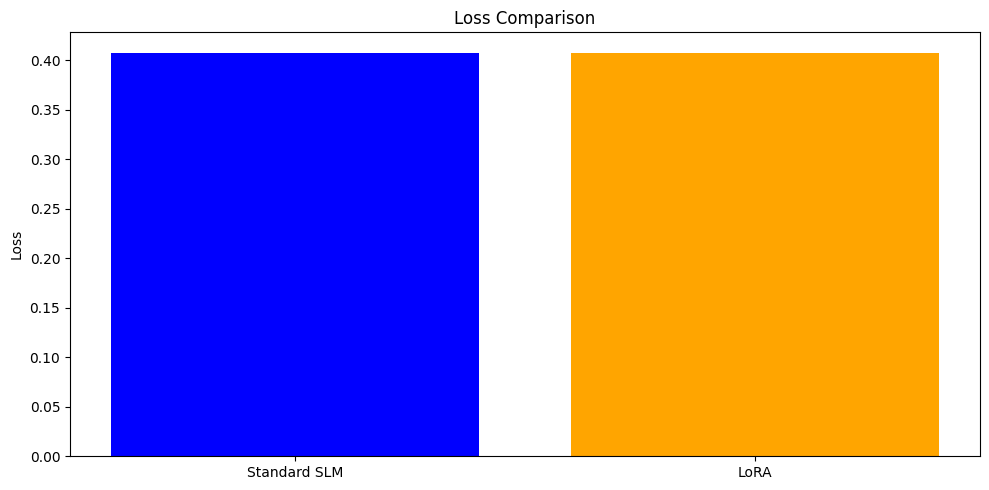

In [4]:
# Evaluation and Comparison
print("Evaluating models...")

# Evaluate Standard SLM
slm_metrics = slm_trainer.evaluate(tokenized_datasets["test"])
print("Standard SLM Test Metrics:", slm_metrics)

# Evaluate LoRA Model
lora_metrics = trainer.evaluate(tokenized_datasets["test"])
print("LoRA Model Test Metrics:", lora_metrics)

# Plot comparison
labels = ["Standard SLM", "LoRA"]
loss = [slm_metrics["eval_loss"], lora_metrics["eval_loss"]]

plt.figure(figsize=(10, 5))

# Loss Comparison
plt.bar(labels, loss, color=['blue', 'orange'])
plt.title("Loss Comparison")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()